## 뷰메진 Assignment Test
### 컴퓨터비전 엔지니어 지원자: 정대현

**핵심 요소**
1. Segmentation backbone network에 대한 이해
2. Pipeline 구축
   data loader → train/validation → test(+evaluation)
3. 문제 해결 능력
4. GitHub을 이용한 코드 관리

**추가 요소**
1. 코딩 스타일
    1. Class
    2. Module
2. 창의적 아이디어
    1. crack segmentation : 오픈 소스 분할 모델 수정하여 crack 검출 성능을 높이기 위한 아이디어
    2. crack measurement : crack 길이와 폭을 측정하는 방법에 대한 아이디어
    3. augmentation : 학습 성능을 높이기 위해 다양한 아이디어

* 모든 이미지 크기는 448x448

### 0. 라이브러리 호출 & 데이터 경로 지정하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random, tqdm
import os, cv2
import math
from glob import glob
#import gc
#gc.enable()
import warnings
warnings.filterwarnings("ignore")
import albumentations as album

#imshow을 사용할때 커널이 죽을 경우 사용
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

segmentation_models_pytorch documents  
https://smp.readthedocs.io/en/latest/index.html

In [2]:
DATA_DIR = './mini_crack_segmentation_dataset/'

x_train_dir = os.path.join(DATA_DIR, 'train/input')
y_train_dir = os.path.join(DATA_DIR, 'train/output')

x_valid_dir = os.path.join(DATA_DIR, 'val/input')
y_valid_dir = os.path.join(DATA_DIR, 'val/output')

x_test_dir = os.path.join(DATA_DIR, 'test/input')
y_test_dir = os.path.join(DATA_DIR, 'test/output')

In [4]:
#배경은 검은색, 크랙은 흰색 (RGB기준)
class_names = ['background', 'crack']
class_rgb_values = [[0, 0, 0], [255, 255, 255]]

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'crack']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### 1. 시각화 함수 설정

In [6]:
def visualize(**images):
    #이미지는 한줄에 표시
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

OpenCV를 이용한 랜덤크롭과 회전 함수  
1. RandomCrop : OpenCV 기반 직접 작성, 50% 확률로 수행  
2. Rotate : OpenCV 기반 직접 작성, 25% 확률로 수행  

In [ ]:
def RandomCrop_Rotate(image, height=224, width=224):
    #랜덤크롭하기(50%)
    num = random.choices(range(0, 2), weights=[1,1])
    if num == 0:
        max_x = image.shape[1] - width
        max_y = image.shape[0] - height
        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)
        image = image[y: y + height, x: x + width]
    
    #회전하기(25%)
    num = random.choices(range(0, 4), weights=[1,1,1,1])
    if num == 0:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
    return image

### 2. 크랙 데이터셋 정의

In [17]:
class crackDataset(torch.utils.data.Dataset):
    """
    이미지 읽기, 확대 적용 및 변환 전처리
    Args:
        images_dir (str): 이미지 폴더 경로
        masks_dir (str): 분할 마스크 폴더 경로
        class_rgb_values (list): 분할 마스크 확대(확대)에서 추출할 선택한 클래스의 RGB 값
        (albumentations.Compose): data transfromation pipeline(e.g. 반전, 스케일 처리 등)
        preprocessing (albumentations.Compose): data preprocessing(e.g. 정규화, 형상 조작, etc.)
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        #경로는 여기서 한번에 불러오기
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # 이미지와 마스크 읽어오기
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # 변환 적용
        if self.augmentation:
            image = RandomCrop_Rotate(image)
            mask = RandomCrop_Rotate(mask)
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #전처리 적용
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        #이미지와 마스크 반환

    def __len__(self):
        # 길이 반환
        return len(self.image_paths)

해당 커스텀 데이터 셋을 통해서 이미지 확인

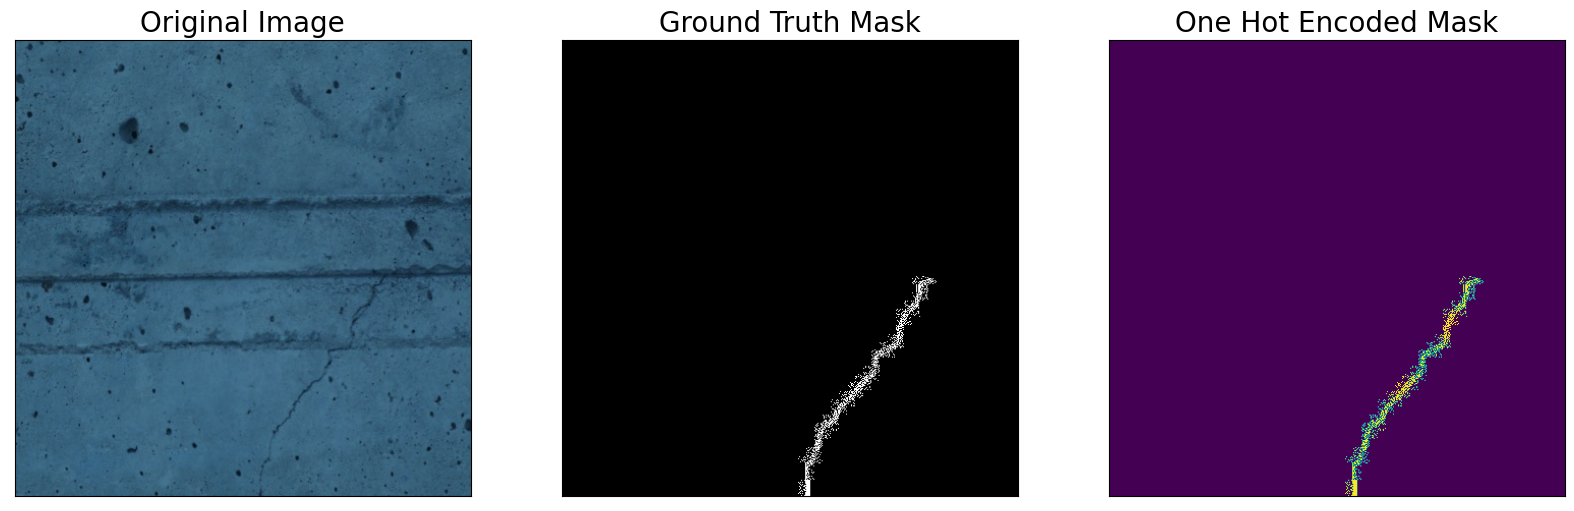

In [19]:
dataset = crackDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### 3. 이미지 augmentation 함수 정의

훈련데이터와 검증데이터의 augmentation정의하기

In [20]:
def get_training_augmentation():
    train_transform = [
        album.Compose([
                album.HorizontalFlip(p=1),
                album.RandomBrightnessContrast(p=1),
                album.RandomRain(p=1),
            ])
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():   
    # 이미지를 32로 분할할 수 있도록 충분한 패딩을 추가(32*48 = 1536)
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """전처리 변환 구성    
    Args:
        preprocessing_fn (callable): 데이터 정규화 함수(사전 훈련된 각 신경망에 대해 특정할 수 있음)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)

정의한 이미지 augmentation 시각화하기

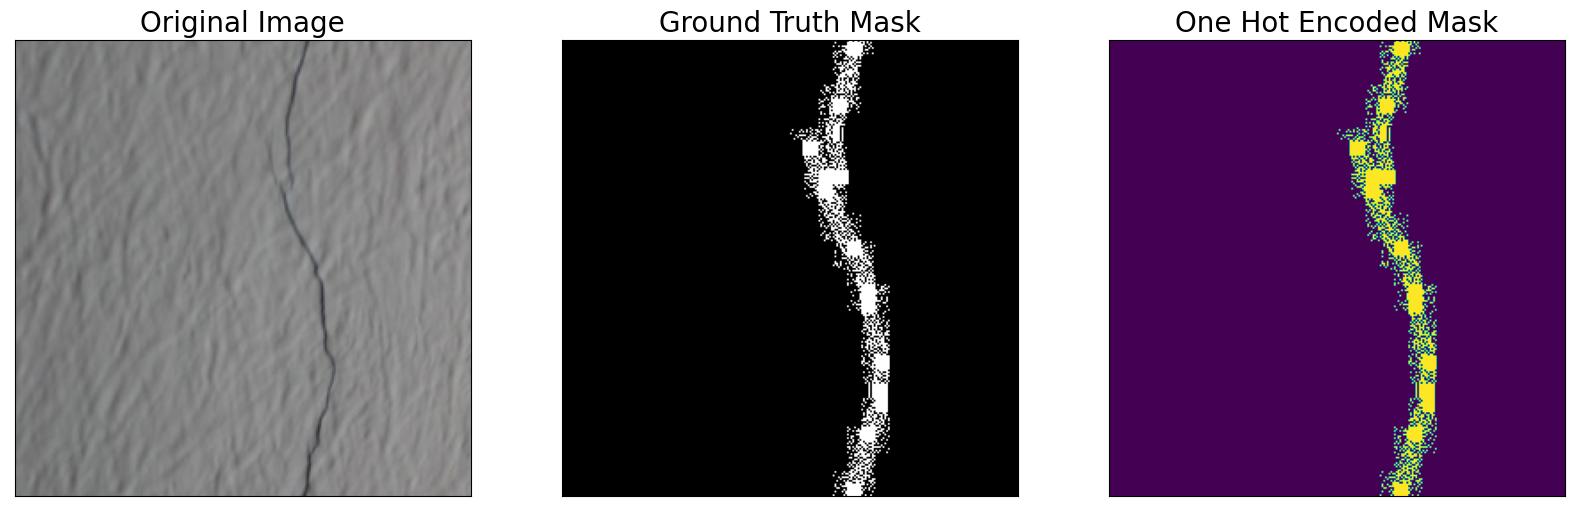

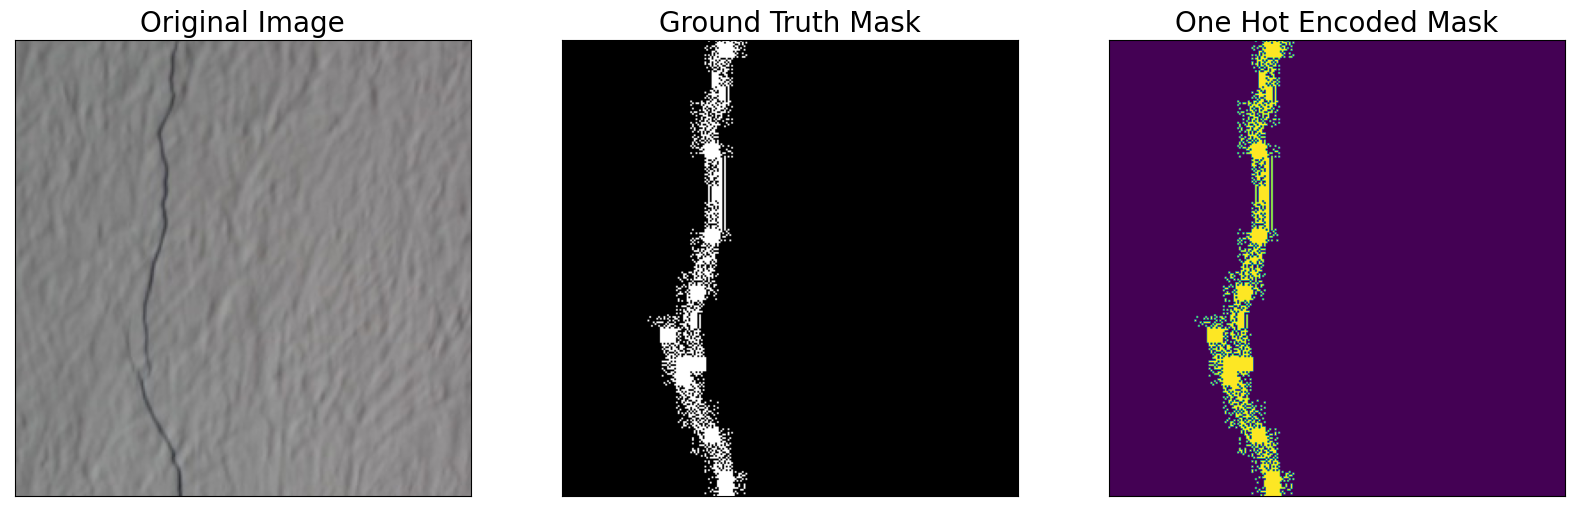

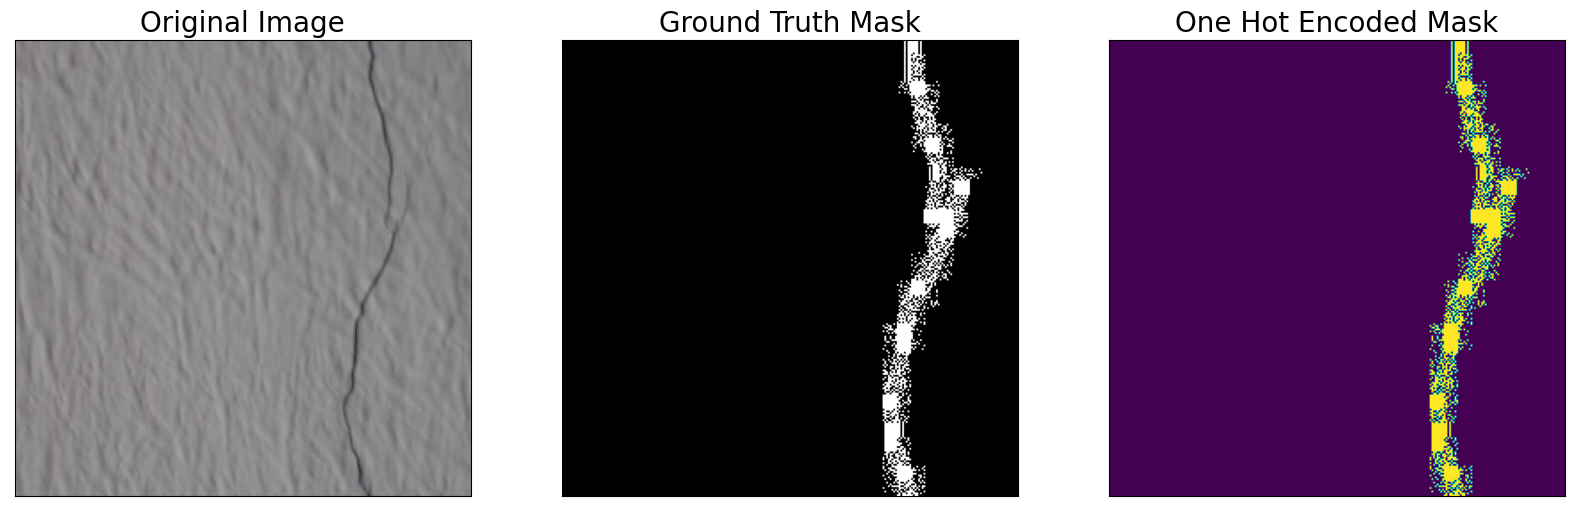

In [25]:
augmented_dataset = crackDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

#이전과 같이 랜덤하게 인덱스 하나 뽑아오기
random_idx = random.randint(0, len(augmented_dataset)-1)

# 랜덤 이미지/마스크 쌍에 대한 다양한 증강(256*256 자르기)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

### 4. 모델 정의 resnet101 + DeepLabV3+

In [26]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

데이터 불러오기

In [28]:
train_dataset = crackDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

valid_dataset = crackDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

하이퍼파라미터 셋팅

In [32]:
TRAINING = True
EPOCHS = 5
#cuda 사용 또는 cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)
if os.path.exists('../deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

조건에 제시한 ifwIoU는
아래 링크 참고해서 만들기
https://smp.readthedocs.io/en/latest/metrics.html#module-segmentation_models_pytorch.metrics.functional

In [33]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

학습 시작

In [ ]:
%%time
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    for i in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid:  36%|███▌      | 181/500 [28:35<46:29,  8.74s/it, dice_loss - 0.8566, iou_score - 0.08121]  

**[Requirements]**
1) Backbone network 모델 구성  
2) OpenCV와 Augmentation을 이용한 Augmentation   
3) Evaluation metric mIoU, ifwIoU  
4) Crack measurement 함수/모듈  
5) 인프런스시 crack mask(png), crack width(number of pixels), crack length(number of pixels) 출력 확인하기

**[Question]**

1) 제안한 모델(들)을 사용한 이유와 근거를 간략히 적어주세요.  
resnet101, DeepLabV3+ 사용한 이유 기술

2) 성능을 향상시키기 위해 노력했다면, 그 내용과 근거를 간략히 적어주세요.  


3) 결과에 대한 본인의 해석을 간략히 적어주세요.  


4) 만약 시간이 더 주어진다면 가장 시도해보고 싶은 것을 하나 제시하고 그 이유에 대해서 간략히 적어주세요.  
